## ML Foundation Course Mini Project ##
#### K-means Clustering of Amazon Climatological Data to Determine Representative Regions ####
Author: Emily Wright - Graduate Trainee (emily.wright@metoffice.gov.uk)

Supervisor: Theo Economou (t.economou@exeter.ac.uk)

Training scoped and funded as part of the Transatlantic Data Science Academy

**Aim:**  Use ML clustering techniques to group together similar areas of the Amazon based on climatological and geological input data

**Use Case:** 
- Be able to use a few ‘representative points’ to model the whole amazon
- Understand how representative the AmazonFACE site is of the rest of the amazon
    - could lead to suggestions of future sites
    - could be used to bias correct data from current site to represent other locations

**Method:** 
- Data wrangling: handling NaNs, removing invalid data, logging data, normalisation
- k-means clustering (using elbow method to determine k)

**Results/Analysis:**
5 clusters (see plot on right). Note AmazonFACE site in region 4 but borderline region 0, suggesting high temp, high precip and med/low phos

**Next Steps:** 
- Consider using more variables such as; Palmer Drought Severity Index, Above Ground Biomass, water table depth
- Consider using other clustering algorithms (and compare)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import iris
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist



Define location paths of data, and regrid phosphorous data to match that of ERA5 data

Save the lattitude and longitude coordinates for plotting later

In [4]:
DATADIR = '/data/users/emwright/model_inputs/ML_Proj_data/Data' # old VDI
DATADIR = '/data/users/emily.wright/old-data/emwright/model_inputs/ML_Proj_data/Data' #new VDI
ERA5_precip = iris.load_cube(f'{DATADIR}/climate/amazon_lowlandprecip_ERA5.nc')
ERA5_temp = iris.load_cube(f'{DATADIR}/climate/amazon_lowlandtemp_ERA5.nc')
phosphorous = iris.load_cube(f'{DATADIR}/soil/amazon_lowlandP.nc')

#regrid phosphurous to match ERA5
phosphorous_regrid = phosphorous.regrid(ERA5_precip, iris.analysis.Linear())

# save lat and lon coords of cube
lats = ERA5_temp.coord('latitude').points
lons = ERA5_temp.coord('longitude').points
#make a meshgrid
lons, lats = np.meshgrid(lons, lats)


Plot scatter of the variables, in order to understand correlations, range and anomalies

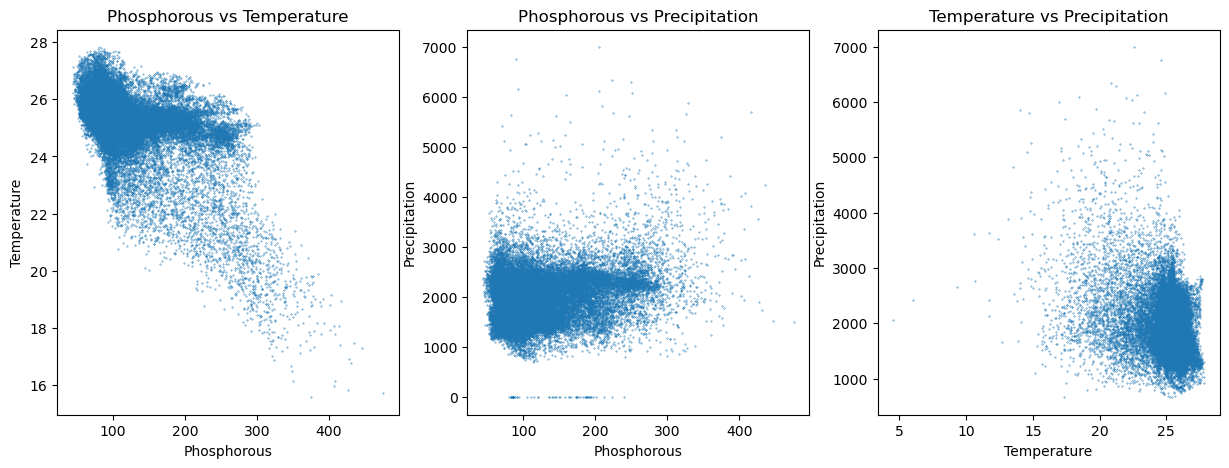

In [5]:
#plot three subplot figure of scatter plot of phosphorous vs temp, phosphorous vs precip, temp vs precip
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(phosphorous_regrid.data.flatten(), ERA5_temp.data.flatten(), s=0.1)
axs[0].set_xlabel('Phosphorous')
axs[0].set_ylabel('Temperature')
axs[0].set_title('Phosphorous vs Temperature')
axs[1].scatter(phosphorous_regrid.data.flatten(), ERA5_precip.data.flatten(), s=0.1)
axs[1].set_xlabel('Phosphorous')
axs[1].set_ylabel('Precipitation')
axs[1].set_title('Phosphorous vs Precipitation')
axs[2].scatter(ERA5_temp.data.flatten(), ERA5_precip.data.flatten(), s=0.1)
axs[2].set_xlabel('Temperature')
axs[2].set_ylabel('Precipitation')
axs[2].set_title('Temperature vs Precipitation')
plt.show()


Now plot a histogram of the phosphorous data to understand the spread. Data looks very skewed and exponential, therefore logged the data

/var/tmp/ipykernel_242062/2640330176.py:3: RuntimeWarning: invalid value encountered in log
  phosphorous_regrid_log.data = np.log(phosphorous_regrid.data)


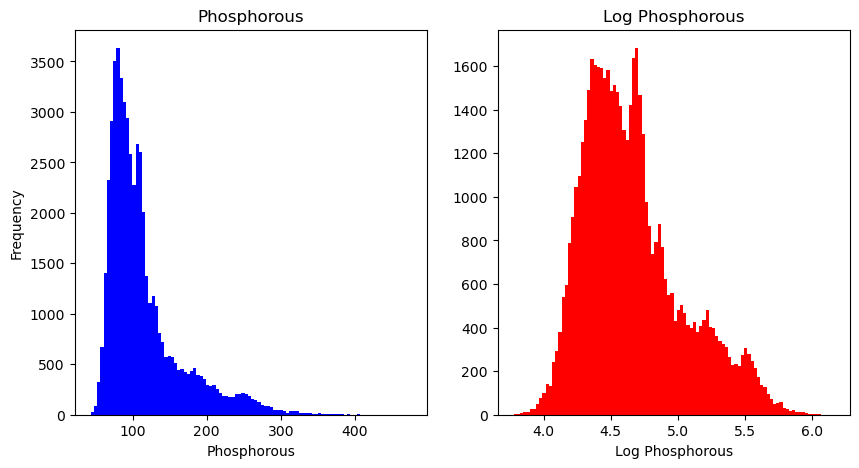

In [6]:
#make a copy of phosphorous_regrid and log the data
phosphorous_regrid_log = phosphorous_regrid.copy()
phosphorous_regrid_log.data = np.log(phosphorous_regrid.data)

#plot two histograms side by side of original phosphorous data and the log phosphorous data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(phosphorous_regrid.data.flatten(), bins=100, color='blue')
axs[0].set_xlabel('Phosphorous')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Phosphorous')
axs[1].hist(phosphorous_regrid_log.data.flatten(), bins=100, color='red')
axs[1].set_xlabel('Log Phosphorous')
axs[1].set_title('Log Phosphorous')
plt.show()


Now plot the phosphorous data and logged data spatially, side by side, to show that the logging doesnt change the premise of the data but better shows the spread of the data

/data/apps/sss/environments/esmvaltool-2.11.0/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/data/apps/sss/environments/esmvaltool-2.11.0/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


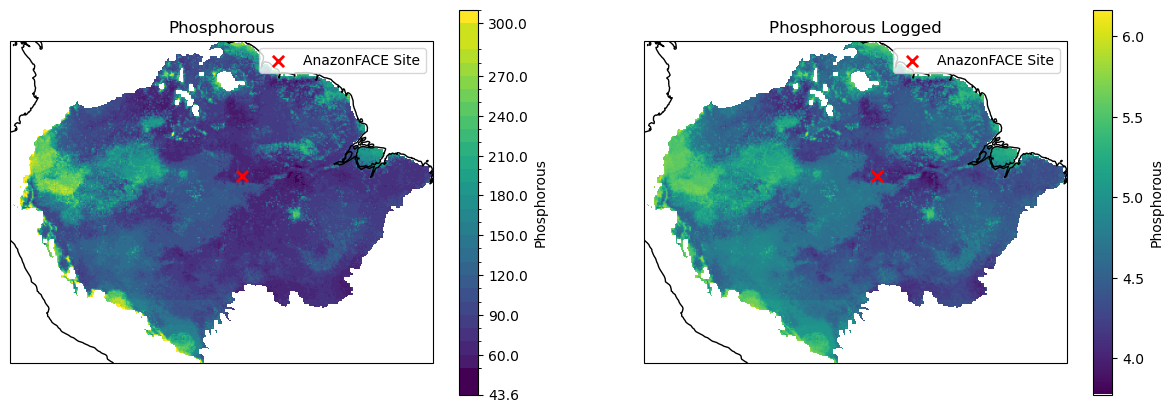

In [7]:
#plot side by side figure of spatial distribution of phosphorous and log phosphorous
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
# Mask NaN values in the phosphorous data
phosphorous_data = np.ma.masked_invalid(phosphorous_regrid.data)
# Define the boundaries for the color bands
bounds = [phosphorous_data.min(), 50] + list(np.linspace(50, 300, num=26)) + [300, phosphorous_data.max()]
norm = BoundaryNorm(bounds, ncolors=plt.cm.viridis.N, clip=True)
axs[0].coastlines()
axs[0].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Create a colormap that sets NaNs to white
cmap = plt.cm.viridis
cmap.set_bad(color='white')
# Plot the data with the custom colormap and normalization
img = axs[0].imshow(phosphorous_data, cmap=cmap, norm=norm, extent=[
    phosphorous_regrid.coord('longitude').points.min(), phosphorous_regrid.coord('longitude').points.max(),
    phosphorous_regrid.coord('latitude').points.min(), phosphorous_regrid.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Phosphorous', ax=axs[0])
axs[0].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[0].set_title('Phosphorous')
axs[0].legend()

# Mask NaN values in the phosphorous data
phosphorous_log_data = np.ma.masked_invalid(phosphorous_regrid_log.data)
# Define norm of data using min and max
norm = plt.Normalize(phosphorous_log_data.min(), phosphorous_log_data.max())
axs[1].coastlines()
axs[1].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Plot the data with the custom colormap and normalization
img = axs[1].imshow(phosphorous_log_data, cmap=cmap, norm= norm, extent=[
    phosphorous_regrid_log.coord('longitude').points.min(), phosphorous_regrid_log.coord('longitude').points.max(),
    phosphorous_regrid_log.coord('latitude').points.min(), phosphorous_regrid_log.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Phosphorous', ax=axs[1])
axs[1].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[1].legend()
axs[1].set_title('Phosphorous Logged')
plt.show()

In [8]:
# #print 2.5th percentile of temperature data ensuring it cant equal nan
# # temp_2_5 = np.nanpercentile(ERA5_temp.data, 2.5)
# temp_5 = np.nanpercentile(ERA5_temp.data, 5)
# # print(temp_2_5)
# print(temp_5)

Now plot a histogram of the temperature data to understand the spread. Has a long tail of low temperatures which are not realistic for lowland (even at Andes foothills) therefore cut off values below 5th percentile (22.937C)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


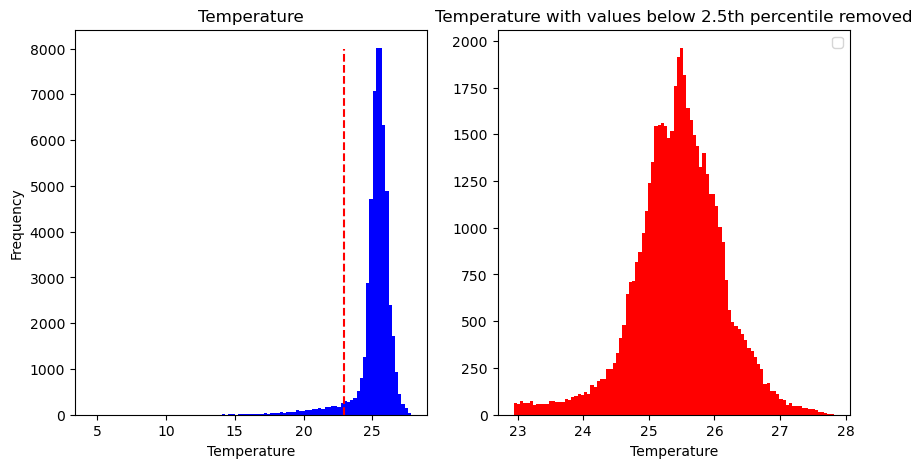

In [9]:
#make a copy of the temperature data and make all values below the 2.5th percentile nan 
temp_data = ERA5_temp.data.copy()
temp_data[temp_data < 22.937] = np.nan

#plot figure of histograms side by side of original temperature data and temperature data with values below 2.5th percentile removed
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(ERA5_temp.data.flatten(), bins=100, color='blue')
axs[0].vlines(22.937, 0, 8000, color='red', label= f'5th percentile ({22.9} C)', linestyles= "dashed")
plt.legend()
axs[0].set_xlabel('Temperature')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Temperature')
axs[1].hist(temp_data.flatten(), bins=100, color='red')
axs[1].set_xlabel('Temperature')
axs[1].set_title('Temperature with values below 2.5th percentile removed')
plt.show()

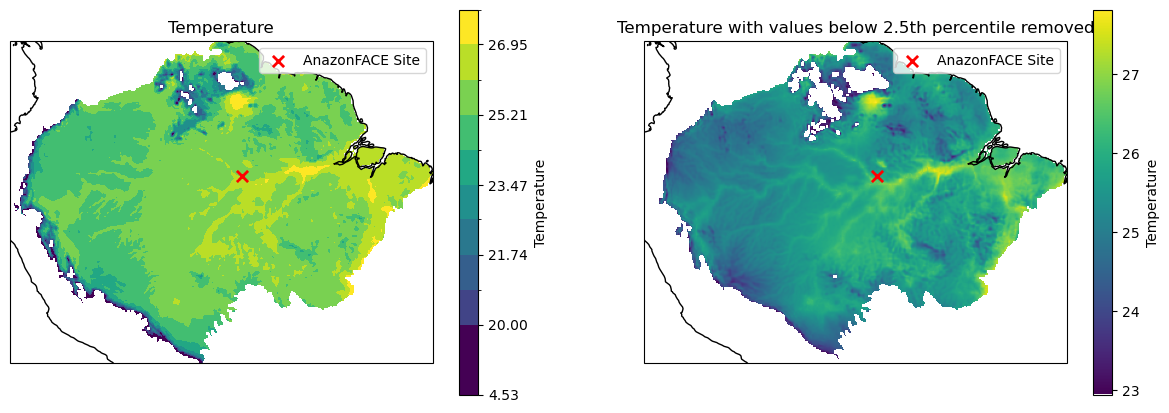

In [10]:
#plot side by side spatial plots of the original temperature data and the new temperature data
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
# Mask NaN values in the temperature data
temperature_data = np.ma.masked_invalid(ERA5_temp.data)# Define the boundaries for the color bands
bounds = [temperature_data.min(), 20] + list(np.linspace(20, temperature_data.max(), num=10))
norm = BoundaryNorm(bounds, ncolors=plt.cm.viridis.N, clip=True)
axs[0].coastlines()
axs[0].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Create a colormap that sets NaNs to white
cmap = plt.cm.viridis
cmap.set_bad(color='white')
# Plot the data with the custom colormap and normalization
img = axs[0].imshow(ERA5_temp.data, cmap=cmap, norm=norm, extent=[
    ERA5_temp.coord('longitude').points.min(), ERA5_temp.coord('longitude').points.max(),
    ERA5_temp.coord('latitude').points.min(), ERA5_temp.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Temperature', ax=axs[0])
axs[0].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[0].set_title('Temperature')
axs[0].legend()

# Mask NaN values in the temperature data
temp_data = np.ma.masked_invalid(temp_data)
axs[1].coastlines()
axs[1].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Plot the data with the custom colormap and normalization
img = axs[1].imshow(temp_data, cmap=cmap, extent=[
    ERA5_temp.coord('longitude').points.min(), ERA5_temp.coord('longitude').points.max(),
    ERA5_temp.coord('latitude').points.min(), ERA5_temp.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Temperature', ax=axs[1])
axs[1].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[1].set_title('Temperature with values below 2.5th percentile removed')
axs[1].legend()
plt.show()


Now plot a histogram of the precipitation data to understand the spread. Firstly, it has an unusal spike at 0 (which is unrealistic) so these are removed. Then there is a long tail of high precipitation so the data is logged

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


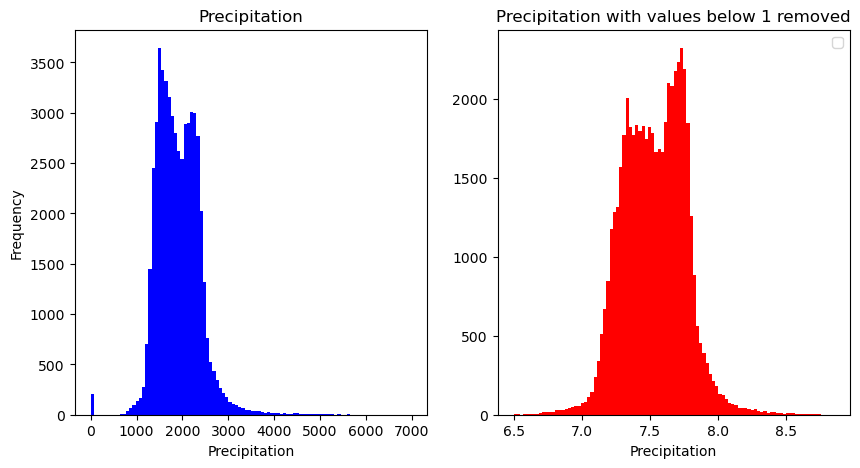

In [11]:
#plot side by side histograms of original precipitation data and precipitation data with values below 1 removed
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(ERA5_precip.data.flatten(), bins=100, color='blue')
plt.legend()
axs[0].set_xlabel('Precipitation')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Precipitation')
precip_cut_data = ERA5_precip.copy()
precip_cut_data.data[precip_cut_data.data < 1] = np.nan
precip_cut_data.data = np.log(precip_cut_data.data)
axs[1].hist(precip_cut_data.data.flatten(), bins=100, color='red')
axs[1].set_xlabel('Precipitation')
axs[1].set_title('Precipitation with values below 1 removed')
plt.show()

Plot the precipitation data and altered data spatially

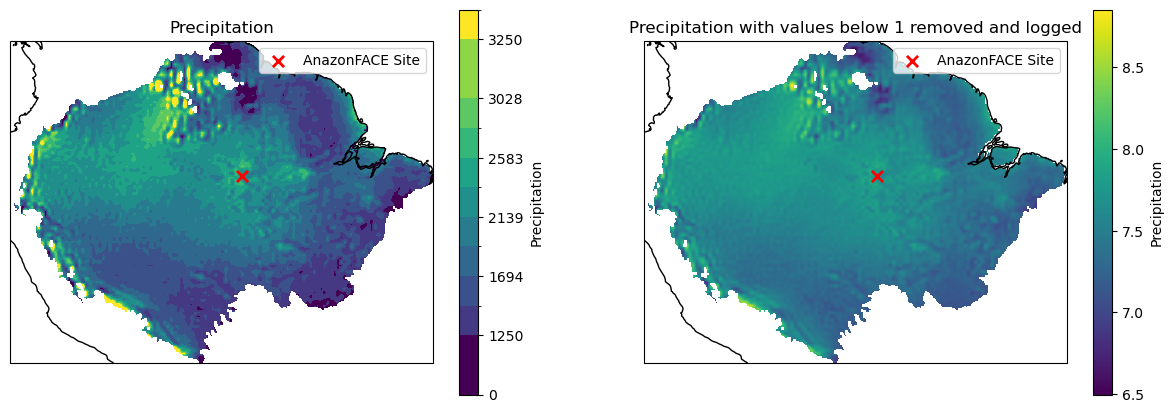

In [12]:
#plot side by side spatial plots of original precipitation data and precipitation data with values below 1 removed and logged
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
# Mask NaN values in the precipitation data
precip_data = np.ma.masked_invalid(ERA5_precip.data)
# Define the boundaries for the color bands
# Define the boundaries for the color bands
bounds = [precip_data.min(), 1250] + list(np.linspace(1250, 3250, num=10)) + [3250, precip_data.max()]
norm = BoundaryNorm(bounds, ncolors=plt.cm.viridis.N, clip=True)
axs[0].coastlines()
axs[0].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Create a colormap that sets NaNs to white
cmap = plt.cm.viridis
cmap.set_bad(color='white')
# Plot the data with the custom colormap and normalization
img = axs[0].imshow(ERA5_precip.data, cmap=cmap, norm=norm, extent=[
    ERA5_precip.coord('longitude').points.min(), ERA5_precip.coord('longitude').points.max(),
    ERA5_precip.coord('latitude').points.min(), ERA5_precip.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Precipitation', ax=axs[0])
axs[0].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[0].set_title('Precipitation')
axs[0].legend()
# Mask NaN values in the precipitation data
precipitation_cut_data = np.ma.masked_invalid(precip_cut_data.data)
# Define norm using min and max
norm_cut = plt.Normalize(precipitation_cut_data.min(), precipitation_cut_data.max())
axs[1].coastlines()
axs[1].add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# Plot the data with the custom colormap and normalization
img = axs[1].imshow(precipitation_cut_data, cmap=cmap, norm=norm_cut, extent=[
    ERA5_precip.coord('longitude').points.min(), ERA5_precip.coord('longitude').points.max(),
    ERA5_precip.coord('latitude').points.min(), ERA5_precip.coord('latitude').points.max()],
    transform=ccrs.PlateCarree(), origin='upper')
plt.colorbar(img, label='Precipitation', ax=axs[1])
axs[1].scatter(-60.208056, -2.594167, marker='x', color='red', s=65, linewidth=2, label="AnazonFACE Site")
axs[1].set_title('Precipitation with values below 1 removed and logged')
axs[1].legend()

Now put this data into a dataframe (here we are using the altered data but could easilt swap for original datasets)

In [13]:
#convert to pandas dataframe
df = pd.DataFrame({'Temperature': temp_data.data.flatten(), 'Precipitation': precipitation_cut_data.data.flatten(), 'Phosphorous': phosphorous_log_data.data.flatten()})
#add lat and lon to dataframe
df['Latitude'] = lats.flatten()
df['Longitude'] = lons.flatten()
# replace any phosporous values that are 1 with nan
df['Phosphorous'].replace(1, np.nan, inplace = True)
df.dropna(inplace = True)
df.head()

,Temperature,Precipitation,Phosphorous,Latitude,Longitude
173,26.166693,6.861474,5.507975,8.6,-62.1
174,26.105549,6.842348,5.508025,8.6,-62.0
175,25.965725,6.824388,5.483335,8.6,-61.9
176,25.801706,6.892711,5.450245,8.6,-61.8
177,25.761215,6.982859,5.442198,8.6,-61.7


Now normalise this data (minus the lat and lon columns)

In [14]:
#normalise daraframe
df_norm = df
df_norm = df_norm.drop(['Latitude', 'Longitude'], axis=1)
df_norm = (df_norm - df_norm.mean()) / df_norm.std()
df_norm.head()

,Temperature,Precipitation,Phosphorous
173,1.073034,-3.080128,2.533231
174,0.982043,-3.168667,2.533377
175,0.773964,-3.251811,2.461724
176,0.529879,-2.935519,2.365689
177,0.469622,-2.518187,2.342337


Now use the elbow method with the sklearn kmeans clustering module to calculate the optimal value of K

In [ ]:
#elbow method to find optimal number of clusters
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(df_norm)
    
    # Calculate distortion as the average squared distance from points to their cluster centers
    distortions.append(sum(np.min(cdist(df_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / df_norm.shape[0])
    
    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Plot the distortion and inertia values to see where the decrease starts being less significant

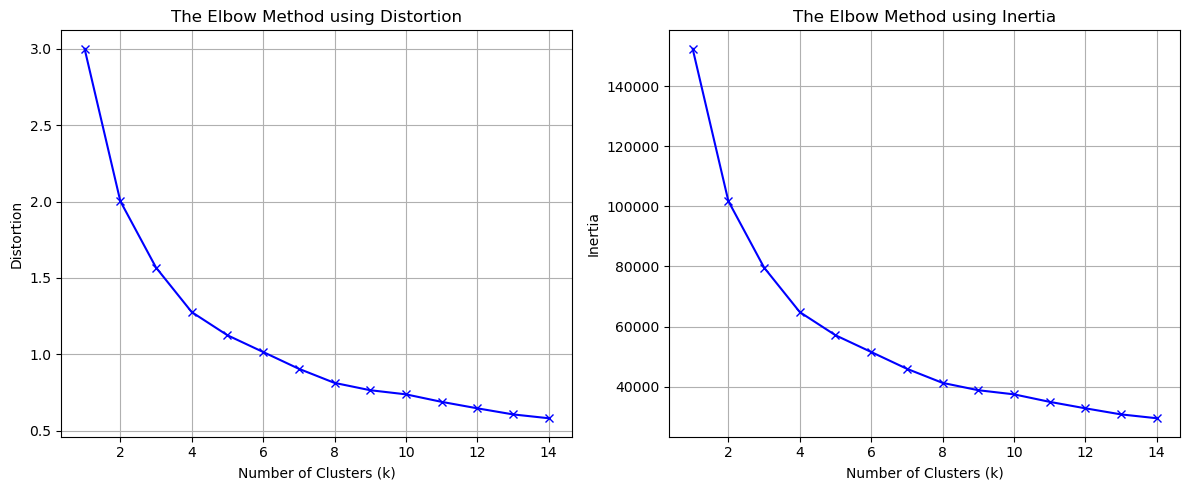

In [20]:
# Create a side by side figure for Distortion and Inertia
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the graph of k versus Distortion
axs[0].plot(K, distortions, 'bx-')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Distortion')
axs[0].set_title('The Elbow Method using Distortion')
axs[0].grid()

# Plotting the graph of k versus Inertia
axs[1].plot(K, inertias, 'bx-')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Inertia')
axs[1].set_title('The Elbow Method using Inertia')
axs[1].grid()

plt.tight_layout()
plt.show()

Finally, put this data into the sklearn kmeans clustering algorithm, for a particular k (have decided range 4-8 is of interest so plotted all). Plot the points in variable space and colour them by their assigned cluster. Found that 4-5 clusters was ideal to still show relevent information from which characteristics can be inferred.

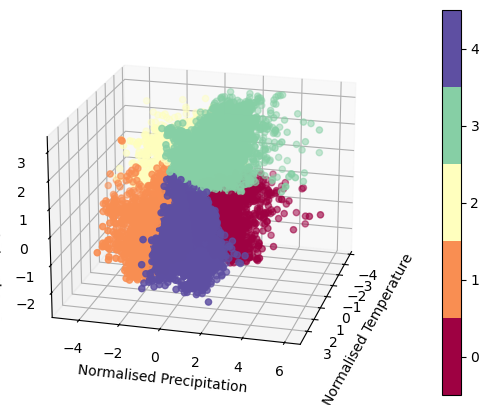

In [23]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
kmeans.fit(df_norm)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot in the scaled and unscaled coordinates.
h = ax.scatter(df_norm["Temperature"], df_norm["Precipitation"], df_norm["Phosphorous"], c=kmeans.labels_, cmap='Spectral')
n = len(np.unique(kmeans.labels_))
plt.colorbar(h, boundaries=np.arange(n+1)-0.5).set_ticks(np.arange(n))

ax.set_xlabel('Normalised Temperature')
ax.set_ylabel('Normalised Precipitation')
ax.set_zlabel('Normalised Phosphorus')

for i in range(kmeans.n_clusters):
    ax.scatter(*kmeans.cluster_centers_[i,:], marker='s', s=100, color="r")

# Rotate the axis around the z dimension
ax.view_init(elev=20, azim=15)  # Adjust the azim parameter to rotate around the z-axis

Then plot the data spatially, coloured by the cluster

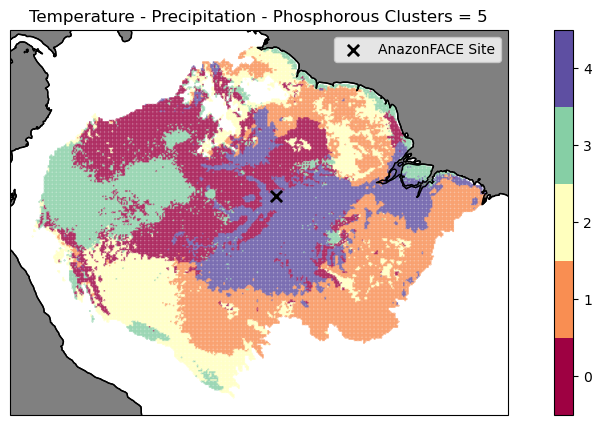

In [24]:
cluster_labels = np.arange(n)

#now plot the data spatially (aka using lat and lon coords) coloring it by the cluster
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 5))
sc = plt.scatter(df["Longitude"], df["Latitude"], c = kmeans.labels_, cmap='Spectral', s = 0.1)
ax.coastlines()
#shade ocean (outline coastlines) to be grey
ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='black', facecolor='grey')
# ax.add_feature(cfeature.STATES, edgecolor = 'black')
plt.colorbar(sc, boundaries=np.arange(n+1)-0.5).set_ticks(np.arange(n))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Temperature - Precipitation - Phosphorous Clusters = {n}')
plt.scatter(-60.208056, -2.594167, marker = 'x', color = 'black', s = 65, linewidth = 2,label = "AnazonFACE Site")
plt.legend()
plt.show()